# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import csv
import winsound

from functions import *
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from scipy.stats import *
from sklearn.inspection import PartialDependenceDisplay

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


%matplotlib notebook
%matplotlib inline
    
%load_ext autoreload
%autoreload 2

# Load features

- load_train_meta(vals = False)
- load_features(vals = False)

In [2]:
n = 0

Xmeta = load_train_meta()
Xwave = load_wave_features()

print("Shape of Xmeta:", Xmeta.shape)
print("Shape of Xwave", Xwave.shape)

Shape of Xmeta: (1100, 5)
Shape of Xwave (1100, 8888)


## Data Exploration

In [3]:
D = Xmeta['direction']
G = Xmeta['group']
S = Xmeta['speed']
L = Xmeta['label']

- plot_sorted_counts(data, label, xtick=True, rot=90, sorted=True, coloring=None)



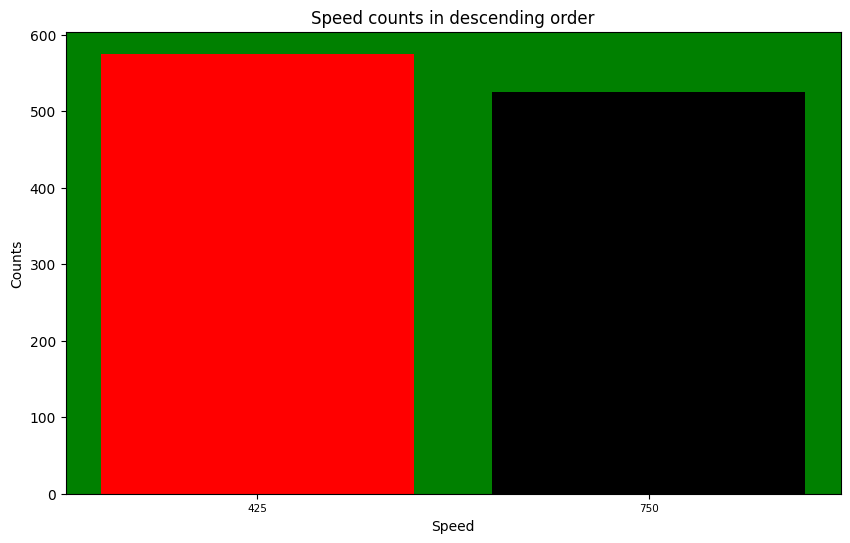

In [4]:
plot_sorted_counts(S, 'Speed', rot = 0)

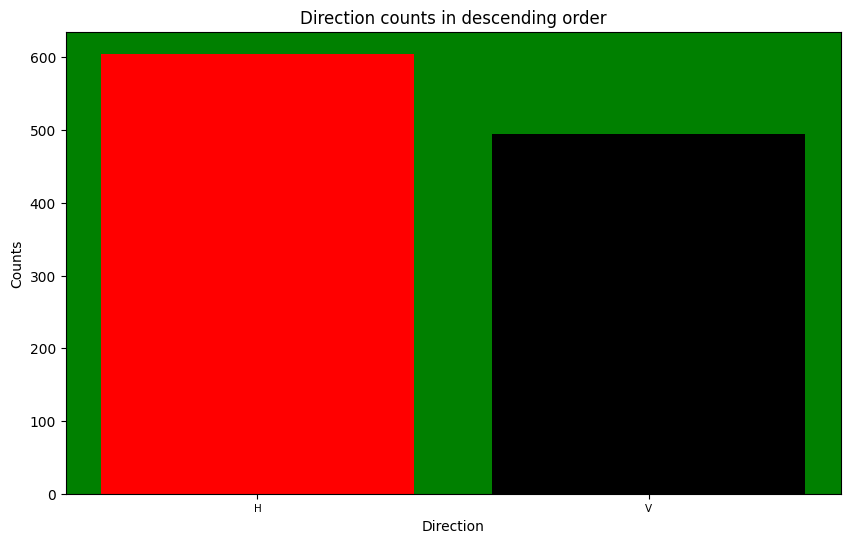

In [5]:
plot_sorted_counts(D, 'Direction', rot = 0)

['DAQ_1' 'DAQ_10' 'DAQ_11' 'DAQ_2' 'DAQ_3' 'DAQ_4' 'DAQ_5' 'DAQ_6' 'DAQ_7'
 'DAQ_8' 'DAQ_9'] [110 100  95 130  95  85 115 100  95 105  70]


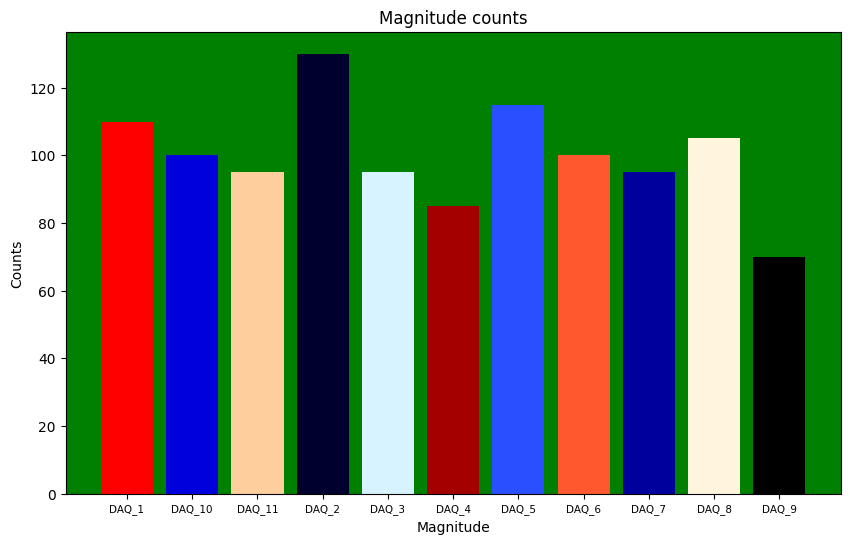

In [6]:
plot_sorted_counts(G, 'Magnitude', rot = 0, sorted=False)

In [7]:
newCols = pd.DataFrame()
newCols['OneHotDirGroup'] = Xmeta['direction'] + '_' + Xmeta['group'].str.split('_').str[1]

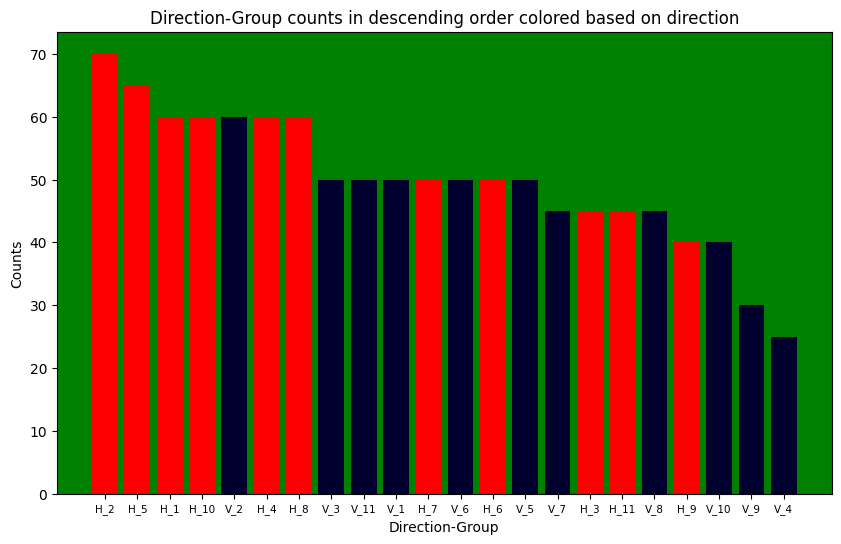

In [8]:
plot_sorted_counts(newCols['OneHotDirGroup'], 'Direction-Group', rot = 0, coloring = 'dir')

In [9]:
newCols['OneHotDirSpeed'] = Xmeta['direction'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

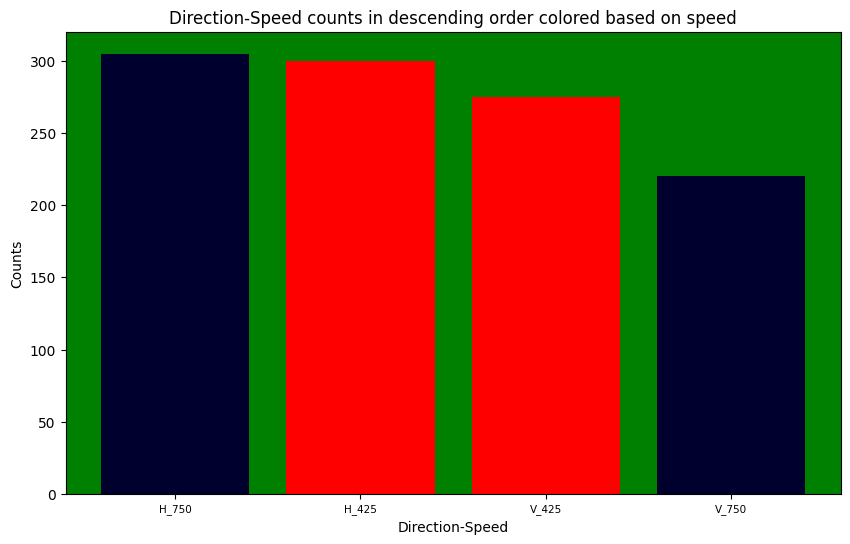

In [10]:
plot_sorted_counts(newCols['OneHotDirSpeed'], 'Direction-Speed', rot = 0, coloring = 'spd')

In [11]:
newCols['OneHotEvr'] = newCols['OneHotDirGroup'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

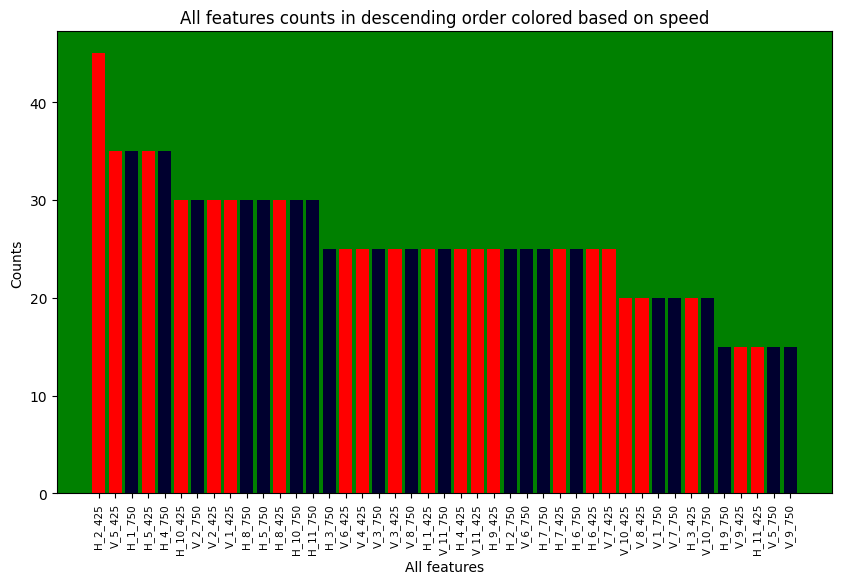

In [12]:
plot_sorted_counts(newCols['OneHotEvr'], 'All features', rot = 90, sorted = True, coloring = 'spd')

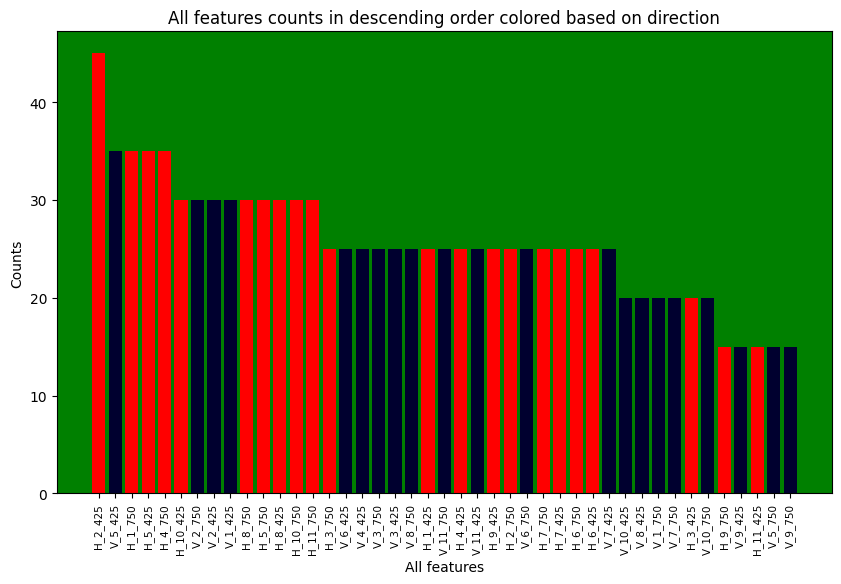

In [13]:
plot_sorted_counts(newCols['OneHotEvr'], 'All features', rot = 90, sorted = True, coloring = 'dir')

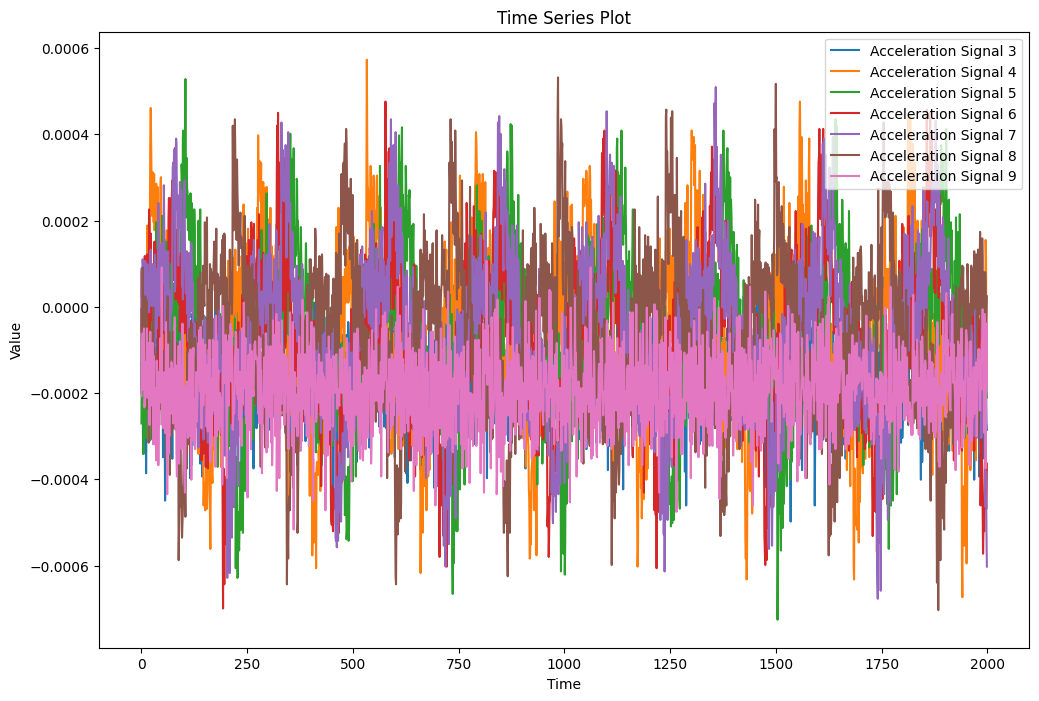

In [14]:
plot_series(3, 10, low = False, high = False, acc = True)

- store_wave_features(store = False)


- get_correlations(X)

In [15]:
# Xwave = load_wave_features()

# get_correlations(Xwave)

In [18]:
# If file does not exist but does not need storing
extractions = store_wave_features()

# If file does not exist and needs storing
# extractions = store_wave_features(store = True)

Wave 0 at index 0 - Progress: 0%
Wave 0 at index 200 - Progress: 2%
Wave 0 at index 400 - Progress: 5%
Wave 0 at index 600 - Progress: 7%
Wave 0 at index 800 - Progress: 9%
Wave 0 at index 1000 - Progress: 11%
Wave 1 at index 0 - Progress: 12%
Wave 1 at index 200 - Progress: 15%
Wave 1 at index 400 - Progress: 17%
Wave 1 at index 600 - Progress: 19%
Wave 1 at index 800 - Progress: 22%
Wave 1 at index 1000 - Progress: 24%
Wave 2 at index 0 - Progress: 25%
Wave 2 at index 200 - Progress: 27%
Wave 2 at index 400 - Progress: 30%
Wave 2 at index 600 - Progress: 32%
Wave 2 at index 800 - Progress: 34%
Wave 2 at index 1000 - Progress: 36%
Wave 3 at index 0 - Progress: 38%
Wave 3 at index 200 - Progress: 40%
Wave 3 at index 400 - Progress: 42%
Wave 3 at index 600 - Progress: 44%
Wave 3 at index 800 - Progress: 47%
Wave 3 at index 1000 - Progress: 49%
Wave 4 at index 0 - Progress: 50%
Wave 4 at index 200 - Progress: 52%
Wave 4 at index 400 - Progress: 55%
Wave 4 at index 600 - Progress: 57%
Wav

## Visualizing Compressed Features per wave

- analyze(X, features, title, labels, scaler=None)

In [ ]:
# # List of preprocessing techinques

# preprocessingList = [PowerTransformer()]


# # Choose which wave and store features (low, high, acc)
# wave = 'acc'
# features = []

# for feature in Xwave.columns:
#     if feature.startswith(wave):
#         features += [feature]

# # Visualize compressed features with preprocessing
# for pre in preprocessingList:
#     analyze(Xwave, features, str(pre)[:-2], Xmeta['label'], pre)


# # Visualize compressed features without any preprocessing (original data)
# # analyze(Xwave, features, 'Original', Xmeta['label'])

# Cross Validation

In [19]:
n_folds = 5

#KFold
cv = KFold(n_splits=n_folds, shuffle=True, random_state = 2211595)

# Training

In [20]:
Xtrain = extractions
Ytrain = Xmeta['label']

# Get the column names and extract histogram and compressed columns for preprocessing
selected_columns = Xtrain.columns
histogram_cols = [col for col in selected_columns if '_h' in col]
compressed_cols = [col for col in selected_columns if '_h' not in col]


print('Shape of Xtrain:', Xtrain.shape)
print('Shape of Ytrain:', Ytrain.shape)

Shape of Xtrain: (1100, 8888)
Shape of Ytrain: (1100,)


In [21]:
preprocessing = ColumnTransformer(
    transformers=[
        ('hist_features', Pipeline([('normalizer', Normalizer())]), histogram_cols),
        ('compressed_features', Pipeline([('minmaxscaler', MinMaxScaler())]), compressed_cols)
    ])

feature_selection = Pipeline([('variancethreshold', VarianceThreshold()), ('selectkbest', SelectKBest())]) 

regressor = Pipeline([('reg', Ridge())])


In [22]:
param_grid = {
    'feature_selection__selectkbest__k' : np.linspace(100, 250, 10, dtype=int),
    'regressor__reg__alpha' : np.logspace(np.log10(0.00200293), np.log10(0.00206986), 10)
}

# print("K grid", np.linspace(10, 700, 20, dtype=int))
# print("Alpha grid", np.logspace(np.log10(0.0018), np.log10(0.00210416), 20))

In [23]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('regressor', regressor)])

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=cv, scoring=mae_scorer, verbose=5, return_train_score=True)
gridsearch.fit(Xtrain, Ytrain)

results = gridsearch.cv_results_

train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print()

print('Best params:')
print(gridsearch.best_params_)

print()

print('Training MAE {}'.format(train_score))
print('Validation MAE: {}'.format(validation_score))

print()

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best params:
{'feature_selection__selectkbest__k': 150, 'regressor__reg__alpha': 0.0020029299999999996}

Training MAE -0.17993433392258376
Validation MAE: -0.19460118380272443



In [24]:
best_estimator = gridsearch.best_estimator_

# Access the SelectKBest transformer
select_k_best = best_estimator.named_steps['feature_selection'][0]

# Get the selected feature indices
selected_indices = select_k_best.get_support()

# Get the names of selected features
selected_feature_names = [Xtrain.columns[i] for i, selected in enumerate(selected_indices) if selected]

print("Selected feature names:", selected_feature_names)

Selected feature names: ['low_min_amplitude', 'low_max_amplitude', 'low_mean_aplitude', 'low_variance', 'low_q_25', 'low_median_amplitude', 'low_q_75', 'low_kurtosis', 'low_skewness', 'low_rms_amplitude', 'low_crest_factor', 'low_h0', 'low_h1', 'low_h2', 'low_h3', 'low_h4', 'low_h5', 'low_h6', 'low_h7', 'low_h8', 'low_h9', 'low_h10', 'low_h11', 'low_h12', 'low_h13', 'low_h14', 'low_h15', 'low_h16', 'low_h17', 'low_h18', 'low_h19', 'low_h20', 'low_h21', 'low_h22', 'low_h23', 'low_h24', 'low_h25', 'low_h26', 'low_h27', 'low_h28', 'low_h29', 'low_h30', 'low_h31', 'low_h32', 'low_h33', 'low_h34', 'low_h35', 'low_h36', 'low_h37', 'low_h38', 'low_h39', 'low_h40', 'low_h41', 'low_h42', 'low_h43', 'low_h44', 'low_h45', 'low_h46', 'low_h47', 'low_h48', 'low_h49', 'low_h50', 'low_h51', 'low_h52', 'low_h53', 'low_h54', 'low_h55', 'low_h56', 'low_h57', 'low_h58', 'low_h59', 'low_h60', 'low_h61', 'low_h62', 'low_h63', 'low_h64', 'low_h65', 'low_h66', 'low_h67', 'low_h68', 'low_h69', 'low_h70', 'low

# Error Analysis

- regression_error_analysis(gridsearch, Xtrain, Ytrain, cv)

In [ ]:
regression_error_analysis(gridsearch, Xtrain, Ytrain, cv)

# Model Prediction

In [26]:
predict_and_store(best_estimator, store_wave_features)

Wave 0 at index 0 - Progress: 0%
Wave 0 at index 200 - Progress: 2%
Wave 0 at index 400 - Progress: 5%
Wave 0 at index 600 - Progress: 7%
Wave 0 at index 800 - Progress: 9%
Wave 0 at index 1000 - Progress: 11%
Wave 1 at index 0 - Progress: 12%
Wave 1 at index 200 - Progress: 15%
Wave 1 at index 400 - Progress: 17%
Wave 1 at index 600 - Progress: 19%
Wave 1 at index 800 - Progress: 22%
Wave 1 at index 1000 - Progress: 24%
Wave 2 at index 0 - Progress: 25%
Wave 2 at index 200 - Progress: 27%
Wave 2 at index 400 - Progress: 30%
Wave 2 at index 600 - Progress: 32%
Wave 2 at index 800 - Progress: 34%
Wave 2 at index 1000 - Progress: 36%
Wave 3 at index 0 - Progress: 38%
Wave 3 at index 200 - Progress: 40%
Wave 3 at index 400 - Progress: 42%
Wave 3 at index 600 - Progress: 44%
Wave 3 at index 800 - Progress: 47%
Wave 3 at index 1000 - Progress: 49%
Wave 4 at index 0 - Progress: 50%
Wave 4 at index 200 - Progress: 52%
Wave 4 at index 400 - Progress: 55%
Wave 4 at index 600 - Progress: 57%
Wav

In [27]:
def done():
    winsound.Beep(300,200)
    winsound.Beep(400,200)
    winsound.Beep(500,200)
    winsound.Beep(600,200)
    winsound.Beep(400,200)
    winsound.Beep(600,400)

In [28]:
done()